** Import block **
==========

Take a notice of cells in the Appendix.
Some sells below depend on these ones.

In [1]:
import os, os.path, re, imp
import numpy as np
import time

from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *

from collections import Counter
from sys import getsizeof

from code.modules.levenshtein import levenshtein_distance
from code.modules.model_simplifier_by_rules import simplify_by_rules
from code.modules.model_reconstructer import model_reconstruct
from code.modules.isomorphism_distance import isomorphism_distance
import code.modules.patterns_extracter as extract_patterns
import code.modules.extract_model_tokens_encodings as extract_tokens_module

import code.input_output.MVRAttributesExtraction as MVRAttributesExtraction
import code.input_output.ReadTokensInfoForOptimization as ReadTokensInfoForOptimization
import code.input_output.DataLoader as DataLoader
import code.data_processing.SegmentatorTS as SegmentatorTS
import code.data_processing.DataPreprocesser as DataPreprocesser

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def get_population_from_file(filename):
    if not filename in filenames:
        print('Error:', filename, 'is not presented in the directory')
    
    lines_file_content = []
    last_non_empty_str = -1

    with open(files_path + filename, 'r') as f_in:
        lines_file_content = (line.rstrip() for line in f_in) # All lines including the blank ones
        non_empty_strings_inds = [ind for ind,line in enumerate(lines_file_content) if line] 
        last_non_empty_str = non_empty_strings_inds[-1]

    lines_file_content = open(files_path + filename, 'r').readlines()[0:last_non_empty_str+1]
    population = np.empty(len(lines_file_content) // 2, dtype = object)
    
    """for ind, entity in enumerate(lines_file_content):          
        model_name = entity.split(' ')[-1]
        population[ind] = re.sub(r'X\[(\d+)\]', r'x\1', model_name.strip())"""
    for ind, entity in enumerate(lines_file_content):          
        if ind % 2 == 0:
            model_name = entity.split(' ')[-1]
            population[ind // 2] = model_name.strip()
                                              
                                          
    return population

In [3]:
config = MVRAttributesExtraction.extract_config()

In [4]:
from configparser import ConfigParser
parser = ConfigParser()
parser.read_dict(config)
parser["data_extraction"]["dataset_filename"] = 'try'
config["data_extraction"]["dataset_filename"]

'/data/data_to_fit.txt'

In [54]:
files_path = 'populations/collected_models20/'
#ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
ts_labels = sorted(['heart_rate', 'chest_volume'])

number_ts_pieces = 76
number_of_retrieved_models = None
tokens_which_param_interest = ['sinc_','sinla_','sinha_']

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]
filenames = sorted(os.listdir(files_path), key=natural_keys)

** Trivial features creation**
==

In [55]:
tokens_codes, _ = create_map_tokens_params('data/tokensInterest.txt')
feature_matrices_of_ts = {label : np.zeros((number_ts_pieces, len(tokens_codes) - 1)) for label in ts_labels}

for label in ts_labels:
    for index in range(number_ts_pieces):
        feature_matrices_of_ts[label][index,:] = get_simple_features_from_segment_of_ts(index, label, spec_numb_models = 3)[:,0]
# feature_matrices_of_ts = {label : scale(feature_matrices_of_ts[label].T) for label in ts_labels}          
unite_feature_matrix = np.vstack((feature_matrices_of_ts[label] for label in ts_labels))

# nstr_fts = nonstructural features
# trv      = only trivial
# tr_fts   = features build on the tree representation (labels of nodes are not treated)
# av_hgt   = average height of tokens

regimes = 'nstr_fts', 'trv', 'nstr_fts + tr_fts', 'tr_fts + av_hgt'
regime = regimes[1]

if regime == 'nstr_fts':
    unite_feature_matrix = np.concatenate((unite_feature_matrix, create_min_max_features()), axis = 1)
    unite_feature_matrix_backup = unite_feature_matrix
elif regime == 'trv':
    unite_feature_matrix_backup = unite_feature_matrix
elif regime == 'nstr_fts + tr_fts':
    unite_feature_matrix = np.concatenate((unite_feature_matrix, create_min_max_features(), create_tree_features_for_all_labels()), axis = 1)
    unite_feature_matrix_backup = unite_feature_matrix
elif regime == 'tr_fts + av_hgt':
    unite_feature_matrix = np.concatenate((unite_feature_matrix, 
                                           create_tree_features_for_all_labels(),
                                           create_averaged_height_vs_tokens_for_all_labels()), 
                                           axis = 1)
    unite_feature_matrix_backup = unite_feature_matrix
unite_feature_matrix.shape

(152, 15)

** Features on parameters of superpositions **
==

In [ ]:
tokens_codes, tokens_params = create_map_tokens_params()
total_num_of_params         = sum(tokens_params.values())
    
feature_matrices_of_ts_ext = {label : np.zeros((number_ts_pieces, total_num_of_params)) for label in ts_labels}

for label in ts_labels:
    for index in range(number_ts_pieces):
        feature_matrices_of_ts_ext[label][index,:] = get_param_features_from_segment_of_ts(index, label, spec_numb_models=None)[:,0]
unite_feature_matrix_add = np.vstack((feature_matrices_of_ts_ext[label] for label in ts_labels))
unite_feature_matrix = np.hstack((unite_feature_matrix_backup, unite_feature_matrix_add)) 
unite_feature_matrix_param_backup = unite_feature_matrix
unite_feature_matrix.shape

In [71]:
indices_of_params_interesting_tokens = get_indices_of_params_interesting_tokens(tokens_which_param_interest)
unite_feature_matrix_add_new = np.array([unite_feature_matrix_add[:,ind] for ind in indices_of_params_interesting_tokens])
unite_feature_matrix_add_new = unite_feature_matrix_add_new.T

unite_feature_matrix = np.hstack((unite_feature_matrix_backup, unite_feature_matrix_add_new)) 
unite_feature_matrix_param_backup = unite_feature_matrix
unite_feature_matrix.shape

(152, 39)

** Pattern features **
==

In [56]:
regime = 'unique'
countered_patterns_dict = {label : get_countered_useful_patterns(label,desired_number_of_patterns=2000,regime=regime) for label in ts_labels}
useful_patterns_dict = {label : sorted(countered_patterns_dict[label].keys()) for label in ts_labels}

useful_patterns = [useful_patterns_dict[label] for label in ts_labels]
#useful_patterns_list = set.difference(*[set(useful_patterns_dict[label]) for label in ts_labels])
regimes = ['union', 'diff']
chosen_regime = regimes[1]
if chosen_regime == 'union':
    useful_patterns_list = set([item for sublist in useful_patterns for item in sublist])
elif chosen_regime == 'diff':
    useful_patterns_list = set(useful_patterns_dict[ts_labels[0]]).difference(set(useful_patterns_dict[ts_labels[1]]))
    useful_patterns_list = useful_patterns_list.union(set(useful_patterns_dict[ts_labels[1]]).difference(set(useful_patterns_dict[ts_labels[0]])) )

#print(useful_patterns_list)
feature_matrices_of_ts = {label : np.zeros((number_ts_pieces, len(useful_patterns_list))) for label in ts_labels}

for label in ts_labels:
    for index in range(number_ts_pieces):
        feature_matrices_of_ts[label][index,:] = \
        get_features_patterns_population(get_population_from_file(create_filename(label,index+1)),list(useful_patterns_list), regime)[:,0]
#unite_feature_matrix_add = np.vstack((feature_matrices_of_ts_ext[label] for label in ts_labels))
unite_feature_matrix_add = np.vstack((feature_matrices_of_ts[label] for label in ts_labels))
generated_features = ['all', 'with_params', 'with_trivial', 'only_patterns']
regime_features = generated_features[2]


if regime_features == 'all':
    unite_feature_matrix = np.hstack((unite_feature_matrix, unite_feature_matrix_add))
elif regime_features == 'with_trivial':
    unite_feature_matrix = np.hstack((unite_feature_matrix_backup, unite_feature_matrix_add))     
elif regime_features == 'only_patterns':
    unite_feature_matrix = unite_feature_matrix_add
elif regime_features == 'with_params':
    unite_feature_matrix = np.hstack((unite_feature_matrix_param_backup, unite_feature_matrix_add))     

unite_feature_matrix.shape

(152, 2412)

In [57]:
ts_labels = list(feature_matrices_of_ts.keys())
ts_labels_in_my_own_order = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
fraction_of_test_samples = 0.1

which_label_is_positive = ts_labels_in_my_own_order[1]
target_vector = np.zeros((unite_feature_matrix.shape[0],1))
ts_labels_in_order_from_dictionary = [label for label in feature_matrices_of_ts]
index_of_label_positive = ts_labels_in_order_from_dictionary.index(which_label_is_positive)
#print('index_of_label_positive = ', index_of_label_positive)
all_inidices_of_samples = np.arange(target_vector.shape[0])
positive_indices_samples = number_ts_pieces * index_of_label_positive + np.arange(number_ts_pieces)
negative_positive_samples = [ind for ind in all_inidices_of_samples if not ind in positive_indices_samples]
target_vector[number_ts_pieces * index_of_label_positive:number_ts_pieces * (index_of_label_positive + 1)] = np.ones((number_ts_pieces,1))
backup_target = target_vector



vector_mistakes_segments = np.zeros(target_vector.shape)
matrix_mutual_interferences = np.zeros((vector_mistakes_segments.size, vector_mistakes_segments.size))
vector_occurences_segments = np.zeros(target_vector.shape)
matrix_occurences_mutual = np.zeros(matrix_mutual_interferences.shape)

for ind in range(matrix_mutual_interferences.shape[0]):
    matrix_occurences_mutual[ind,ind] = 0
    
from sklearn.svm import SVC
trials = 500
cumulative_error = 0
cumulative_error_pos = 0
cumulative_error_neg = 0

for trying in range(trials):
    indices_of_test_sample = np.random.choice([True, False], len(all_inidices_of_samples), p = [fraction_of_test_samples, 1 - fraction_of_test_samples])
    target_vector = 2* backup_target - 1 
    train_matrix = unite_feature_matrix[~indices_of_test_sample,:]
    test_matrix = unite_feature_matrix[indices_of_test_sample,:]
    train_target = target_vector[~indices_of_test_sample].reshape(sum(~indices_of_test_sample),)
    test_target = target_vector[indices_of_test_sample].reshape(sum(indices_of_test_sample),)
    
    
            
    clf = SVC(kernel='linear')
    clf.fit(train_matrix, train_target) 
    
    predictions = clf.predict(test_matrix)
    errors = predictions != test_target
    
    renew_measurements_errors(vector_mistakes_segments, matrix_mutual_interferences, vector_occurences_segments, matrix_occurences_mutual, indices_of_test_sample, errors)
    
    cumulative_error += sum(errors) / len(errors)
    cumulative_error_pos += sum(errors[test_target == max(test_target)]) / len(errors[test_target == max(test_target)])
    cumulative_error_neg += sum(errors[test_target == min(test_target)]) / len(errors[test_target == min(test_target)])

cumulative_error /= trials
cumulative_error_pos /= trials
cumulative_error_neg /= trials

print("error = ", cumulative_error)
print("error on positive = ", cumulative_error_pos)
print("error on negative = ", cumulative_error_neg)

vector_mistakes_segments    = vector_mistakes_segments / vector_occurences_segments
matrix_mutual_interferences = matrix_mutual_interferences / matrix_occurences_mutual

os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % ( 1, 700))

error =  0.0400678797558
error on positive =  0.0
error on negative =  0.0810434149184


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in true_divide


0

In [78]:
indices = list(range(1,vector_mistakes_segments.size + 1))
hardest_indices = np.array(sorted(indices, key = lambda x: -vector_mistakes_segments[x-1]), dtype = int).T
print(hardest_indices)
hardest_indices = hardest_indices - 1

[ 16  19  36  52  58  60  66  98 134 149 118  87  42  62  47 137  81  85
  44  50  35  45 151  26 141 136 107  77  63  27  61  41  94   5 109 108
  56  39 132 115 131  89 147 101 120  70 111  54 140  86  95  80  55  76
  13 139  10  65  21 153  82  97  49  64  74   1   2   3   4   6   7   8
   9  11  12  14  15  17  18  20  22  23  24  25  28  29  30  31  32  33
  34  37  38  40  43  46  48  51  53  57  59  67  68  69  71  72  73  75
  78  79  83  84  88  90  91  92  93  96  99 100 102 103 104 105 106 110
 112 113 114 116 117 119 121 122 123 124 125 126 127 128 129 130 133 135
 138 142 143 144 145 146 148 150 152 154]


In [58]:
ts_labels

['heart_rate', 'open_apple']

In [129]:
indices_sorted_errousness = np.vstack((hardest_indices, vector_mistakes_segments[hardest_indices].T))
print_numpy_object("indices_sorted_errousness")

IndexError: index 200 is out of bounds for axis 0 with size 200

In [111]:
matrix_mutual_interferences = matrix_mutual_interferences * matrix_occurences_mutual

In [240]:
print_numpy_object('vector_mistakes_segments')
print_numpy_object('matrix_mutual_interferences')

In [248]:
indices_of_test_sample = np.random.choice([True, False], len(all_inidices_of_samples), p = [fraction_of_test_samples, 1 - fraction_of_test_samples])
target_vector = 2* backup_target - 1 
train_matrix = unite_feature_matrix[~indices_of_test_sample,:]
test_matrix = unite_feature_matrix[indices_of_test_sample,:]
train_target = target_vector[~indices_of_test_sample].reshape(sum(~indices_of_test_sample),)
test_target = target_vector[indices_of_test_sample].reshape(sum(indices_of_test_sample),)

clf = SVC(kernel='linear')
clf.fit(train_matrix, train_target) 
print(clf.n_support_)
predictions = clf.predict(test_matrix)
#print("predictions: ", predictions)
errors = predictions != test_target

print("error = ", sum(errors) / len(errors))
print("error on positive = ", sum(errors[test_target == max(test_target)]) / len(errors[test_target == max(test_target)]))
print("error on negative = ", sum(errors[test_target == min(test_target)]) / len(errors[test_target == min(test_target)]))

[27 28]
error =  0.5
error on positive =  0.375
error on negative =  0.571428571429


In [239]:
from sklearn import neighbors, datasets



h = .02  # step size in the mesh
error = np.inf
where_min = -1
trials = 30

for n_neighbors in 1 + np.arange(30):
    for weights in ['uniform', 'distance']:
        cumulative_error = 0
        for trying in range(trials):
            indices_of_test_sample = np.random.choice([True, False], len(all_inidices_of_samples), p = [fraction_of_test_samples, 1 - fraction_of_test_samples])
            target_vector = 2* backup_target - 1 
            train_matrix = unite_feature_matrix[~indices_of_test_sample,:]
            test_matrix = unite_feature_matrix[indices_of_test_sample,:]
            train_target = target_vector[~indices_of_test_sample].reshape(sum(~indices_of_test_sample),)
            test_target = target_vector[indices_of_test_sample].reshape(sum(indices_of_test_sample),)
            
            # we create an instance of Neighbours Classifier and fit the data.
            clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
            clf.fit(train_matrix, train_target)

            predictions = clf.predict(np.c_[test_matrix])
            errors = predictions != test_target
            
            cumulative_error = cumulative_error + (sum(errors) / len(errors))
        if cumulative_error / trials < error:
            where_min = n_neighbors
            error = cumulative_error / trials


where_min, error

(4, 0.32674108737859137)

** Structural metrics (Levenshtein on strings and graphs) **
==

In [118]:
def distance_between_populations_string(population_first, population_second):
    len_first, len_second = len(population_first), len(population_second)
    # calculate sum of distances for all pairs of models: one from first population, the other from second
    cumulative_distance = 0
    for model_from_first in population_first:
        for model_from_second in population_second:
            cumulative_distance = cumulative_distance + levenshtein_distance(model_from_first, model_from_second)
    cumulative_distance = cumulative_distance / (len_first * len_second)
    return cumulative_distance

In [119]:
def distance_between_populations_trees(population_first, population_second):
    len_first, len_second = len(population_first), len(population_second)
    # calculate sum of distances for all pairs of models: one from first population, the other from second
    cumulative_distance = 0
    for model_from_first in population_first:
        for model_from_second in population_second:
            cumulative_distance = cumulative_distance + isomorphism_distance(model_from_first, model_from_second)
    cumulative_distance = cumulative_distance / (len_first * len_second)
    return cumulative_distance

In [120]:
def create_matrix_of_codes_of_one_population(number_of_file, type_of_ts, tokens_codes):
    codes = 'QWERTYUIOPASDFGHJKLZXCVBNM123456789/*-+=?!'
    filename = type_of_ts + '_' + str(number_of_file + 1) + '.txt'
    models = get_population_from_file(filename)
    
    matrix_representation = []    
    for model in models:
        matr, encodings = dfs_search_on_handle(model)
        encodings = np.array(encodings)
        if len(model) == 0:
            break
        matrix_representation.append(''.join(np.array(list(codes))[encodings]))

    return matrix_representation
    #return primitive_frequences.reshape(-1,1)

** Create string-format DFS-code of the final selected models stored in the corresponding files **

In [121]:
tokens_codes, _ = create_map_tokens_params()
feature_matrices_of_ts = {label : [] for label in ts_labels}
    
for label in ts_labels:
    for index in range(number_ts_pieces):
        feature_matrices_of_ts[label].append(create_matrix_of_codes_of_one_population(index, label, tokens_codes))

In [126]:
distances_between_segments = np.zeros((len(ts_labels) * number_ts_pieces, len(ts_labels) * number_ts_pieces))

start = time.time()

indices_vs_labels = list(enumerate(feature_matrices_of_ts))

for ind_f in range(distances_between_segments.shape[0]):
    for ind_s in range(distances_between_segments.shape[0]):
        label_f = indices_vs_labels[ind_f // number_ts_pieces][1]
        label_s = indices_vs_labels[ind_s // number_ts_pieces][1]
        
        #population_f = feature_matrices_of_ts[label_f][ind_f % number_ts_pieces]
        #population_s = feature_matrices_of_ts[label_s][ind_s % number_ts_pieces]
        population_f = get_population_from_file(label_f + '_' + str(ind_f % number_ts_pieces + 1) + '.txt')
        population_s = get_population_from_file(label_s + '_' + str(ind_s % number_ts_pieces + 1) + '.txt')
        
        if ind_f <= ind_s:
            if ind_f == 0 and ind_s == 0:
                print(population_f[0], population_s[0])
            distances_between_segments[ind_f][ind_s] = distance_between_populations_string(population_f[0:None], population_s[0:None])
        else:
            distances_between_segments[ind_f][ind_s] = distances_between_segments[ind_s][ind_f]
            
end = time.time()
print(end - start)
os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % ( 1, 700))

parabola_(sinla_(normal_(sinha_(abs_(x0))))) parabola_(sinla_(normal_(sinha_(abs_(x0)))))
834.4540574550629


0

In [127]:
trials = 200
measurements = np.zeros(trials)
for ii in range(trials):
    fraction_of_test_samples = 0.3

    indices_of_test_sample = np.random.choice([True, False], number_ts_pieces, p = [fraction_of_test_samples, 1 - fraction_of_test_samples])
    indices_of_test_sample = np.arange(number_ts_pieces)[indices_of_test_sample]
    indices_to_search = np.setdiff1d(range(number_ts_pieces), indices_of_test_sample)
    #indices_to_search = np.hstack((indices_to_search, indices_to_search + number_ts_pieces * np.ones(indices_to_search.shape)
    #                               , indices_to_search + 2 * number_ts_pieces * np.ones(indices_to_search.shape)))
    indices_to_search = np.hstack((indices_to_search, indices_to_search + number_ts_pieces * np.ones(indices_to_search.shape)))

    responses = np.empty((len(ts_labels) * len(indices_of_test_sample), 1))

    indices_to_search = np.array(indices_to_search, dtype = int)
    for ind_label in range(len(ts_labels)):
        for index_of_index, index in enumerate(indices_of_test_sample):
            index_in_matrix  = ind_label * number_ts_pieces + index
            row_for_analysis = distances_between_segments[index_in_matrix,:] 

            #nearest_neighbor_label = int(find_closest_elem(row_for_analysis, indices_to_search) // number_ts_pieces)
            nearest_neighbor_label = indices_to_search[np.argmin(row_for_analysis[indices_to_search])] // number_ts_pieces        
            responses[len(indices_of_test_sample) * ind_label + index_of_index] = nearest_neighbor_label

    true_responses = np.zeros((len(ts_labels) * len(indices_of_test_sample), 1))
    for i in range(len(ts_labels)):
        true_responses[i*len(indices_of_test_sample):(i+1)*len(indices_of_test_sample)] = i * np.ones((len(indices_of_test_sample), 1))
    measurements[ii] = sum(responses != true_responses) / len(true_responses)
    #print("error = ", sum(responses != true_responses) / len(true_responses))
print("error = ", np.mean(measurements))

error =  0.463668036678


In [47]:
def find_closest_elem(row_for_analysis, indices_to_search):
    minim = np.Inf
    posit = -1
    for ind in indices_to_search:
        if row_for_analysis[ind] < minim:
            posit = ind
            minim = row_for_analysis[ind]
    return posit

In [50]:
random_state = 50
clusters = KMeans(n_clusters=len(ts_labels), random_state=random_state,n_init = 10).fit_predict(distances_between_segments)
true_clusters = np.zeros(len(ts_labels) * number_ts_pieces)
for ind,_ in enumerate(ts_labels):
    true_clusters[ind * number_ts_pieces:(ind + 1) * number_ts_pieces] = ind * np.ones(number_ts_pieces)
print(sum(clusters != true_clusters) / len(clusters))
clusters

0.615384615385


array([0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int32)

In [51]:
random_state = 170
clusters = AgglomerativeClustering(n_clusters=len(ts_labels)).fit_predict(distances_between_segments)
print(sum(clusters != true_clusters) / len(clusters))
clusters

0.371794871795


array([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
fraction_of_test_samples = 0.3

test_indices = np.random.choice([True, False], number_ts_pieces, p = [fraction_of_test_samples, 1 - fraction_of_test_samples])
target_vector = 2* target_vector - 1 

train_matrix = unite_feature_matrix[~indices_of_test_sample,:]
test_matrix = unite_feature_matrix[indices_of_test_sample,:]
train_target = target_vector[~indices_of_test_sample].reshape(sum(~indices_of_test_sample),)
test_target = target_vector[indices_of_test_sample].reshape(sum(indices_of_test_sample),)

** N APPENDIX **
==

In [7]:
def renew_tokens_file():
    file = open('code/primitives/Primitives.txt', 'r')
    lines = file.readlines()[1:]
    file.close()
    file_dest = open('data/tokensInterest.txt', 'w')
    for line in lines:
        file_dest.write(line)
    file_dest.write('X[0] 0 1 0\n')
    file_dest.write('X[1] 0 1 0')
    file_dest.close()
    
#renew_tokens_file()

In [8]:
def get_population_from_file(filename):
    if not filename in filenames:
        print('Error:', filename, 'is not presented in the directory')
    
    lines_file_content = []
    last_non_empty_str = -1

    with open(files_path + filename, 'r') as f_in:
        lines_file_content = (line.rstrip() for line in f_in) # All lines including the blank ones
        non_empty_strings_inds = [ind for ind,line in enumerate(lines_file_content) if line] 
        last_non_empty_str = non_empty_strings_inds[-1]

    lines_file_content = open(files_path + filename, 'r').readlines()[0:last_non_empty_str+1]
    population = np.empty(len(lines_file_content) // 2, dtype = object)
    
    """for ind, entity in enumerate(lines_file_content):          
        model_name = entity.split(' ')[-1]
        population[ind] = re.sub(r'X\[(\d+)\]', r'x\1', model_name.strip())"""
    for ind, entity in enumerate(lines_file_content):          
        if ind % 2 == 0:
            model_name = entity.split(' ')[-1]
            population[ind // 2] = model_name.strip()
                                              
                                          
    return population

In [9]:
def find_num_vars_and_tokens(handle):    
    counter_tokens = 0
    counter_variables = 0

    for i in range(len(handle)):
        if handle[i] == '_': 
            counter_tokens += 1
        elif i < len(handle)-1 and handle[i] == 'X' and handle[i+1] == '[':
            counter_variables += 1;

    return (counter_tokens, counter_variables)

In [10]:
def create_map_tokens_params(filename = 'data/tokensInterest.txt'):
    file_opened = open(filename, 'r')
    primitives_lines = file_opened.readlines()
    tokens_codes = {line.split()[0] : int(ind) for ind,line in enumerate(primitives_lines)}    
    tokens_params = {line.split()[0] : int(line.split()[1]) for line in primitives_lines}    
    return (tokens_codes, tokens_params)

In [11]:
def dfs_search_on_handle(handle):
    counters = find_num_vars_and_tokens(handle)
    number_tokens = counters[0] + counters[1]
    
    waiting_tokens = []
    encodings = np.zeros(number_tokens, dtype = int)        
    current_token, left, right = 0, 0, 0
    is_a_token_processed_now = False    
    
    map_tokens_params = create_map_tokens_params()[0]
    
    for right in range(len(handle)):
        if handle[right] == '_':
            # the root is detected
            waiting_tokens.append(current_token)
            token = handle[left:right + 1]
            encodings[current_token] = map_tokens_params.get(token, -1)
            right += 1
            break;  
    
    matr = [[] for i in range(number_tokens)]            
    
    # now process the remaining vertices
    reserved_right = right
    for right in np.arange(right, len(handle)):
        if handle[right] == ')':
            waiting_tokens.pop()        
    
        if not is_a_token_processed_now and handle[right].isalpha():
            is_a_token_processed_now = True
            left = right
    
        # if a token is found
        if handle[right] == '_':
            # new token is detected
            current_token += 1
            matr[waiting_tokens[-1]].append(current_token)
            waiting_tokens.append(current_token)
            token = handle[left:right + 1]
            encodings[current_token] = map_tokens_params.get(token, -1)
            is_a_token_processed_now = False      
        
        # if a variable is found
        if right < len(handle)-1 and handle[right] == 'X' and handle[right+1] == '[':
            # new variable is detected
            current_token += 1
            matr[waiting_tokens[-1]].append(current_token)
            while right < len(handle)-1 and handle[right] != ']':
                right += 1
            token = handle[left:right + 1]
            encodings[current_token] = map_tokens_params.get(token, -1)
            is_a_token_processed_now = False            
    
    return (matr, encodings)

In [12]:
def incidence_to_adjacency(incidence):
    size_of_mat = len(incidence)
    adjacency = np.zeros((size_of_mat, size_of_mat))    
    for ind, row in enumerate(incidence):
        adjacency[ind][row] = 1
    return adjacency

** Collect primitive structural features from a population of models**
=====================================

In [13]:
def get_simple_features_from_segment_of_ts(number_of_file, type_of_ts, spec_numb_models = None):
        
    tokens_codes, _ = create_map_tokens_params()
    filename = type_of_ts + '_' + str(number_of_file + 1) + '.txt'
    
    if spec_numb_models:
        models = get_population_from_file(filename)[0:spec_numb_models]
    else:
        models = get_population_from_file(filename)[0:number_of_retrieved_models]
    primitive_frequences = np.zeros(len(tokens_codes) - 1, dtype = float)
    lower_bound_code_variables = tokens_codes.get('X[0]', len(tokens_codes))
    
    for model in models:
        matr, encodings = dfs_search_on_handle(model)
        model_primitive_frequences = Counter(encodings)
        for key in model_primitive_frequences:
            if key >= 0 and key < len(tokens_codes) - 1:
                primitive_frequences[key] += (model_primitive_frequences[key] / len(model_primitive_frequences))
    #return scale(primitive_frequences.reshape(-1,1), axis=0)
    
    #primitive_frequences[-1] = len(encodings)
    #return normalize(primitive_frequences.reshape(-1,1), axis=1)
    return scale(primitive_frequences.reshape(-1,1))
    #return primitive_frequences.reshape(-1,1)

** Create features on parameters of nonlinear functions **
==

In [14]:
def get_parameters_from_file(filename):
    if not filename in filenames:
        print('Error:', filename, 'is not presented in the directory')
    
    lines_file_content = []
    last_non_empty_str = -1

    with open(files_path + filename, 'r') as f_in:
        lines_file_content = (line.rstrip() for line in f_in) # All lines including the blank ones
        non_empty_strings_inds = [ind for ind,line in enumerate(lines_file_content) if line] 
        last_non_empty_str = non_empty_strings_inds[-1]

    lines_file_content = open(files_path + filename, 'r').readlines()[0:last_non_empty_str+1]
    population = np.empty(len(lines_file_content) // 2, dtype = object)
    
    array_of_parameters = []
    
    for ind, entity in enumerate(lines_file_content):          
        if ind % 2 == 1:
            if len(entity) > 1:
                list_of_parameters = list(map(float,entity.split(', ')))
                array_of_parameters.append(np.array(list_of_parameters))
    return array_of_parameters

In [15]:
def get_ordered_list_tokens(filename = 'data/tokensInterest.txt'):
    file_opened = open(filename, 'r')
    primitives_lines = file_opened.readlines()
    tokens_names = [line.split()[0] for line in primitives_lines]
    return tokens_names

In [16]:
def get_array_ranges_parameters(array_param_nums):
    array_ranges = [[0,array_param_nums[0]],]    
    for ind, param_num in enumerate(array_param_nums):
        if ind == 0:
            continue
        array_ranges.append([array_ranges[-1][-1],array_ranges[-1][-1]+param_num])
    return array_ranges

In [17]:
def do_bsxfun_to_params(model, parameters, averaged = False):
    tokens_codes, tokens_params = create_map_tokens_params()
    tokens_names                  = get_ordered_list_tokens()
    matr, encodings               = dfs_search_on_handle(model)

    model_tokens     = [tokens_names[i] for i in encodings]
    array_param_nums = [tokens_params[tokens_names[i]] for i in encodings]
        
    array_ranges_parameters = get_array_ranges_parameters(array_param_nums)
    bsxfun_to_params = {token : np.zeros(tokens_params[token]) for ind, token in enumerate(tokens_names)}
    for ind, token in enumerate(model_tokens):
        bsxfun_to_params[token] += parameters[array_ranges_parameters[ind][0]:array_ranges_parameters[ind][1]]
    
    if averaged:
        countered = Counter(model_tokens)
        bsxfun_to_params = {token : bsxfun_to_params[token] / countered[token] for token in tokens_names if countered[token]>0}
    
    return bsxfun_to_params

In [18]:
def get_param_features_from_segment_of_ts(number_of_file, type_of_ts, spec_numb_models = None):
    tokens_codes, tokens_params = create_map_tokens_params()
    tokens_names                = get_ordered_list_tokens()
    total_num_of_params         = sum(tokens_params.values())
    
    filename = type_of_ts + '_' + str(number_of_file + 1) + '.txt'
    array_of_parameters = []
    population = []
    if spec_numb_models:
        array_of_parameters = get_parameters_from_file(filename)[0:spec_numb_models]
        population          = get_population_from_file(filename)[0:spec_numb_models]
    else:
        array_of_parameters = get_parameters_from_file(filename)[0:number_of_retrieved_models]
        population          = get_population_from_file(filename)[0:number_of_retrieved_models]
    
    cumulated_params = np.zeros(total_num_of_params)
    def sigmoid_array(x):                                        
        return 1 / (1 + np.exp(-x))

    for model, parameters in zip(population, array_of_parameters):
        bsxfun_to_params    = do_bsxfun_to_params(model, parameters)
        row = np.array([param for token in tokens_names for param in bsxfun_to_params[token]])
        cumulated_params   += row
    
    return scale(cumulated_params.reshape(-1,1), axis=0)
    #return normalize(cumulated_params.reshape(-1,1))
    #return cumulated_params.reshape(-1,1)

In [19]:
def get_set_of_tokens_params_values(label):
    tokens_names  = get_ordered_list_tokens()
    set_of_values = {token : [] for token in tokens_names}
    
    for num_file in range(number_ts_pieces):
        filename = label + '_' + str(num_file + 1) + '.txt'
        array_of_parameters = get_parameters_from_file(filename)[0:number_of_retrieved_models]
        population          = get_population_from_file(filename)[0:number_of_retrieved_models]

        for model, parameters in zip(population, array_of_parameters):
            bsxfun_to_params    = do_bsxfun_to_params(model, parameters)
            
            for token in bsxfun_to_params:
                set_of_values[token].append(bsxfun_to_params[token])
                    
    return set_of_values

In [20]:
def get_indices_of_params_interesting_tokens(interesting_tokens):
    tokens_codes, tokens_params = create_map_tokens_params()
    tokens_names                = get_ordered_list_tokens()
    total_num_of_params         = sum(tokens_params.values())

    array_param_nums = [tokens_params[token] for token in tokens_names]

    array_ranges_parameters = get_array_ranges_parameters(array_param_nums)

    array_params_interest = []
    for token in tokens_which_param_interest:
        range_params = array_ranges_parameters[tokens_names.index(token)]
        array_params_interest.extend(list(np.arange(range_params[0], range_params[1], 1)))

    return array_params_interest

** Extract and work with patterns of models from the stored populations ** 
==

In [21]:
def extract_patterns_from_model(model_handle):
    unite_string_with_patterns = extract_patterns.extract_patterns(model_handle)
    patterns = unite_string_with_patterns.split('&')
    return patterns

In [22]:
model = 'times2_(parabola_(frac2_(X[0],hypot_(X[0],normal_(X[0])))),times2_(parabola_(X[0]),plus2_(sina_(normal_(X[0])),times2_(sina_(X[0]),sina_(X[0])))))'
extract_patterns_from_model(model)

['frac2_(,hypot_(,normal_()))', 'times2_(bump_(),bump_())', 'bump_(normal_)']

In [23]:
def clear_patterns_from_vars(patterns):
    for ind in range(len(patterns)):
        patterns[ind] = re.sub(r'\(X\[\d+\]\)','',patterns[ind])
    return patterns

In [24]:
def collect_patterns_from_population(population, regime):
    patterns = []
    for model in population:
        model = model_reconstruct(model)
        patterns.extend(extract_patterns_from_model(model))
    patterns = [item for item in patterns if item]
    patterns = clear_patterns_from_vars(patterns)
    if regime == 'all':
        return patterns
    elif regime =='unique':
        return list(set(patterns))

In [25]:
def collect_patterns_from_label(label, regime):
    patterns = []
    for i in np.arange(1, number_ts_pieces, 1):
        retrieved_patterns = collect_patterns_from_population(get_population_from_file(label+'_'+str(i)+'.txt'), regime)
        patterns.extend(retrieved_patterns[0:number_of_retrieved_models])
    return patterns

In [29]:
collect_patterns_from_label("heart_rate", "unique")

['neg_(expl_(sinc_))',
 'times2_(sinla_(sinha_()),parabola_(normal_()))',
 'sinla_(normal_(sinc_(sinc_)))',
 'plus2_(normal_(sinc_(sinc_())),)',
 'parabola_(normal_(parabola_(sinc_)))',
 'times2_(normal_(expl_()),parabola_())',
 'times2_(sinla_(normal_(sinc_(sinc_()))),sinla_(sinha_()))',
 'sinla_(sinha_)',
 'normal_(sinha_)',
 'expl_(expl_(sinc_))',
 'times2_(parabola_(normal_()),parabola_(normal_(sinha_(expl_()))))',
 'times2_(sinla_(sinha_()),parabola_(normal_(sinla_(sinc_(sinla_())))))',
 'times2_(expl_(),)',
 'times2_(parabola_(normal_()),parabola_(normal_(parabola_(sinc_()))))',
 'times2_(sinc_(),)',
 'times2_(parabola_(),parabola_(sinc_(normal_())))',
 'times2_(sinla_(sinha_()),parabola_())',
 'times2_(sinha_(),)',
 'frac2_(parabola_(sinc_(sinc_(sinc_()))),)',
 'parabola_(sinc_(normal_))',
 'parabola_(normal_(sinla_(sinc_)))',
 'times2_(sinla_(sinha_()),parabola_(normal_(sinla_(sinc_()))))',
 'times2_(sinla_(sinha_()),expl_(expl_(sinc_())))',
 'neg_(sinc_)',
 'times2_(sinla_(sin

In [30]:
def get_popular_patterns(label, regime, threshhold_popularity = 20):
    
    patterns = collect_patterns_from_label(label, regime)
    countered_patterns = Counter(patterns)

    popular_patterns = [item for item in set(patterns) if countered_patterns[item] >= threshhold_popularity]
    
    return popular_patterns

In [31]:
def get_threshhold_for_patterns_selection(label, desired_number_of_patterns, regime):
    
    threshhold_popularity = 0

    patterns = collect_patterns_from_label(label, regime)
    unique_patterns = set(patterns)
    countered_patterns = Counter(patterns)

    for threshhold_popularity in np.arange(1,1000,1):
        popular_patterns = [item for item in unique_patterns if countered_patterns[item] >= threshhold_popularity]
        if len(popular_patterns) <= desired_number_of_patterns:
            break
    return threshhold_popularity

In [32]:
def get_countered_useful_patterns(label,desired_number_of_patterns = 40, regime = 'unique'):
    
    threshhold_popularity = get_threshhold_for_patterns_selection(label,desired_number_of_patterns, regime)
    unique_popular_patterns = get_popular_patterns(label, regime, threshhold_popularity)

    all_patterns = collect_patterns_from_label(label, regime)
    popular_counter_to_count = [item for item in all_patterns if item in unique_popular_patterns]
    return Counter(popular_counter_to_count)

In [33]:
def get_features_patterns_population(population, useful_patterns_list, regime):
    patterns = collect_patterns_from_population(population, regime)
    countered_patterns = Counter(patterns)
    
    features = [countered_patterns.get(item,0) for item in useful_patterns_list]
    #return normalize(np.array(features,dtype=float).reshape(-1,1), axis = 1)
    return scale(np.array(features,dtype=float).reshape(-1,1))
    #return np.array(features,dtype=float).reshape(-1,1)

In [34]:
def create_filename(label, number_of_segment):
    return label + '_' + str(number_of_segment) + '.txt'

** Retrieve nonstructural features **
==

In [35]:
def create_min_max_features():
    config = MVRAttributesExtraction.attributes_extraction()
    number_of_segments = int(config["time_series_processing"]["number_of_segments"])
    # we add two nonstructural features, may be usefull for improving classification
    minmax_features = np.zeros((number_ts_pieces * len(ts_labels),1))

    for ind_segment in range(number_ts_pieces):
        for ind_label, label in enumerate(ts_labels):

            whole_ts_to_fit = DataLoader.retrieve_ts(config, label)
            list_ts_to_fit  = SegmentatorTS.segmentate_ts(whole_ts_to_fit, int(config["time_series_processing"]["number_of_segments"]))

            ts_to_fit           = DataPreprocesser.data_preprocesser(list_ts_to_fit[ind_segment])[:,0]
            minmax_features[ind_segment + ind_label * number_ts_pieces] = - min(ts_to_fit) + max(ts_to_fit)
            minmax_features = scale(minmax_features)
    return minmax_features

** Create structural features based on the construction of models trees **
==
** Examples: depth, width, fullness, size **

In [36]:
def find_tree_nodes_heights(tree):
    heights = np.zeros((len(tree)), dtype = int)
    visited, stack = set(), [0]
    while stack:        
        vertex = stack[-1]
        if vertex not in visited:
            visited.add(vertex)
            stack.extend(tree[vertex])
        else:
            if tree[vertex]:
                heights[vertex] = max([heights[ind] + 1 for ind in tree[vertex]])
            vertex = stack.pop()
    return heights

In [37]:
def create_tree_features_of_population(label, ind_segment):
    filename = create_filename(label, ind_segment)
    population = get_population_from_file(filename)
    population_tree_fts = {'height' : [], 'width' : [], 'size' : []}
    for model in population:
        tree, _ = dfs_search_on_handle(model)
        heights = find_tree_nodes_heights(tree)
        levels_sizes = Counter(heights)
        
        population_tree_fts['height'].append(heights[0])
        population_tree_fts['width'].append(max(levels_sizes.values()))
        population_tree_fts['size'].append(len(tree))
        
    population_tree_fts = {'height' : np.mean(population_tree_fts['height']), 
                           'width' : np.mean(population_tree_fts['width']),
                           'size' : np.mean(population_tree_fts['size'])}
    
    return population_tree_fts

In [38]:
def create_tree_features_of_label(label):
    label_tree_fts = {'height' : np.zeros(number_ts_pieces), 
                           'width' : np.zeros(number_ts_pieces), 
                           'size' : np.zeros(number_ts_pieces)}
    for i in range(number_ts_pieces):
        population_tree_fts = create_tree_features_of_population(label, i + 1)
        for key in label_tree_fts:
            label_tree_fts[key][i] = population_tree_fts[key]
    
    matrix_form_tree_features = np.vstack((label_tree_fts[label] for label in label_tree_fts)).T
        

    return matrix_form_tree_features

In [39]:
def create_tree_features_for_all_labels():
    return scale(np.vstack((create_tree_features_of_label(label) for label in ts_labels)))

** Averaged heights **

In [40]:
def create_averaged_height_vs_tokens_label(label):
    tokens_names = get_ordered_list_tokens()[:-1]
    averaged_height_features = np.zeros((number_ts_pieces, len(tokens_names)))
    
    for i in range(number_ts_pieces):
        population = get_population_from_file(create_filename(label, i + 1))
        for model in population:
            tree, encodings = dfs_search_on_handle(model)
            heights = find_tree_nodes_heights(tree)
            
            temp_dict_heights = {tokens_names[code] : [] for code in encodings if code < len(tokens_names)}

            for j in range(len(heights)):
                if encodings[j] < len(tokens_names):
                    temp_dict_heights[tokens_names[encodings[j]]].append(heights[j])
            
            averaged_height_features[i,:] += np.array([np.mean(temp_dict_heights.get(token, [0])) for token in tokens_names])              
        averaged_height_features[i,:] = (averaged_height_features[i,:] / len(population))
        
    return averaged_height_features

In [41]:
def create_averaged_height_vs_tokens_for_all_labels():
    return scale(np.vstack((create_averaged_height_vs_tokens_label(label) for label in ts_labels)))

** Additional functional for casual work **
==

In [45]:
def bool_indexing_to_int(bool_indices):
    return np.array([ind for ind, val in enumerate(bool_indices) if val], dtype = int)

In [46]:
def renew_measurements_errors(vector_mistakes_segments, matrix_mutual_interferences,
                             vector_occurences_segments, matrix_occurences_mutual,
                             indices_of_test_sample, errors):
    int_indices_test_sample  = bool_indexing_to_int(indices_of_test_sample)
    int_indices_train_sample = bool_indexing_to_int(~indices_of_test_sample)
    int_indices_errors           = bool_indexing_to_int(errors)
    
    for ind in int_indices_test_sample:
        vector_occurences_segments[ind] += 1
    
    for ind_te in int_indices_test_sample:
        for ind_tr in int_indices_train_sample:
            matrix_occurences_mutual[ind_te][ind_tr] += 1
            #matrix_occurences_mutual[ind_tr][ind_te] += 1
    
    for ind in int_indices_errors:
        vector_mistakes_segments[int_indices_test_sample[ind]] += 1
    
    for ind_te in int_indices_errors:
        for ind_tr in int_indices_train_sample:
            matrix_mutual_interferences[int_indices_test_sample[ind_te]][ind_tr] += 1

In [47]:
def print_numpy_object(obj_name_string):
    np.savetxt(obj_name_string + ".csv", eval(obj_name_string), delimiter=",", fmt='%.2f')

** Preset some arrays and matrices **

** Analysis of distributions of features **
==

In [48]:
def find_total_number_of_tokens_in_population(index_of_segment, label, number_of_retrieved_models = None):
    filename = label + '_' + str(index_of_segment + 1) + '.txt'
    population = get_population_from_file(filename)[0:number_of_retrieved_models]
    total_number = 0
    for model in population:
        total_number += extract_tokens(model).count('&') + 1
        
    return total_number

In [49]:
def find_token_frequency_in_population(token, index_of_segment, label):
    number_of_retrieved_models = None
    filename = label + '_' + str(index_of_segment + 1) + '.txt'
    population = get_population_from_file(filename)[0:number_of_retrieved_models]
    
    times_occur = 0
    total_number = find_total_number_of_tokens_in_population(index_of_segment, label, number_of_retrieved_models)
    for model in population:
        tokens_names = extract_tokens(model).split('&')
        times_occur += tokens_names.count(token)
    frequency = times_occur / total_number
    
    return frequency

In [6]:
tokens_names = get_ordered_list_tokens()
number_of_tokens = len(tokens_names)

for index_of_token in range(number_of_tokens):
    token_processed = tokens_names[index_of_token]
    frequencies_token = np.zeros((number_ts_pieces,len(ts_labels)))
    
    for ind_label, label in enumerate(ts_labels):
        for ind_of_segment in range(number_ts_pieces):
            frequencies_token[ind_of_segment,ind_label] = \
                            find_token_frequency_in_population(token_processed, ind_of_segment, label)
    
    plt.figure(index_of_token + 1, figsize = (10,4))
    
    bins = np.linspace(0, .5, 50)
    for ind, label in enumerate(ts_labels):
        plt.hist(frequencies_token[:,ind], bins, alpha=0.3, label=label)
    plt.title(token_processed)
    plt.legend(loc='upper right')

plt.show()

NameError: name 'get_ordered_list_tokens' is not defined

** Analysis on the tokens parameters distribution **

In [67]:
config = MVRAttributesExtraction.attributes_extraction()
info_tokens = ReadTokensInfoForOptimization.read_info_tokens_for_optimization(config)

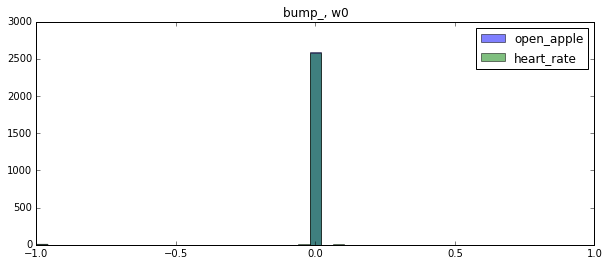

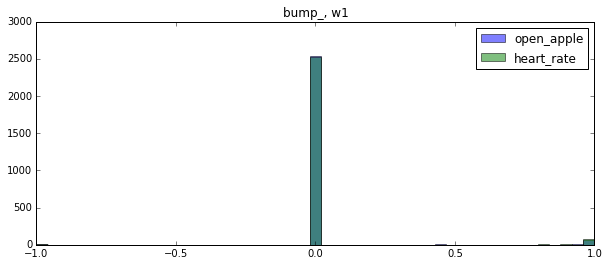

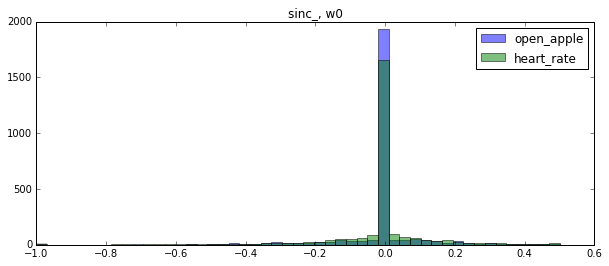

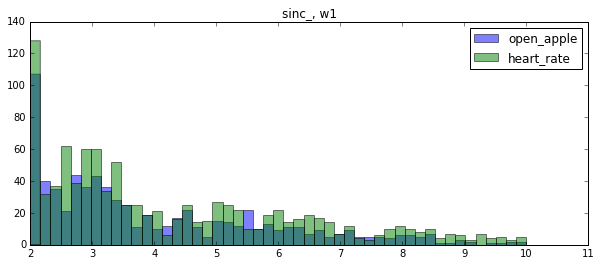

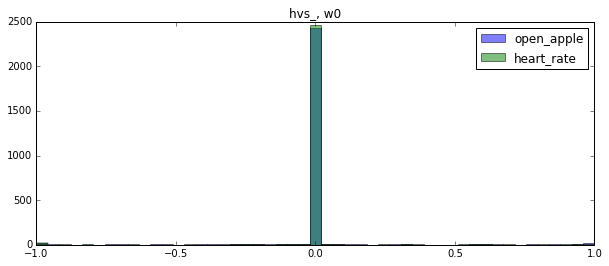

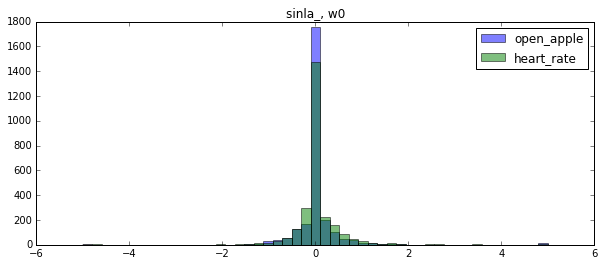

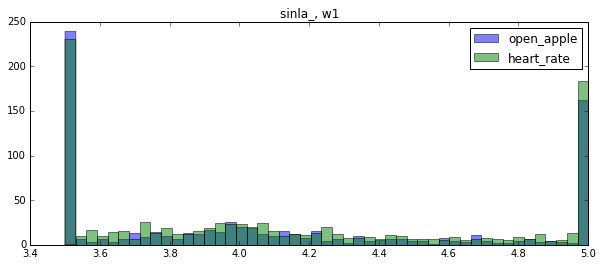

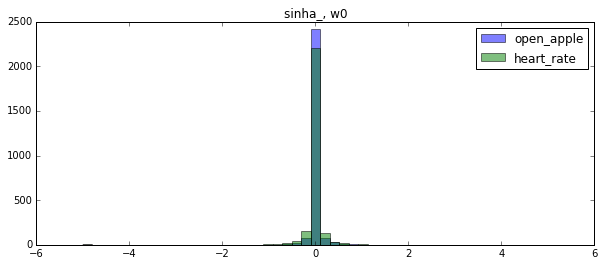

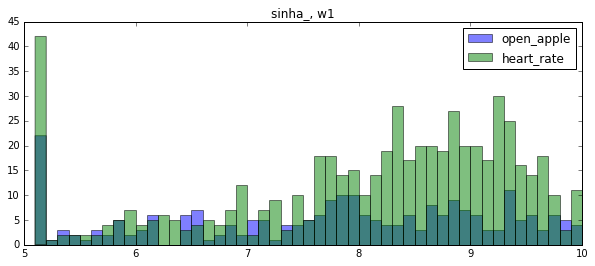

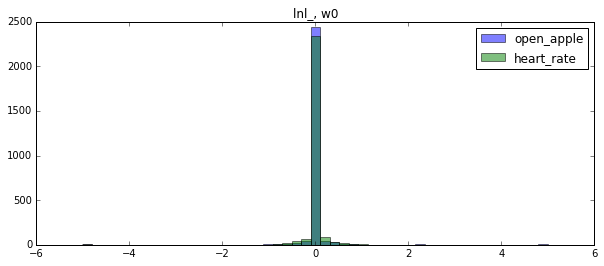

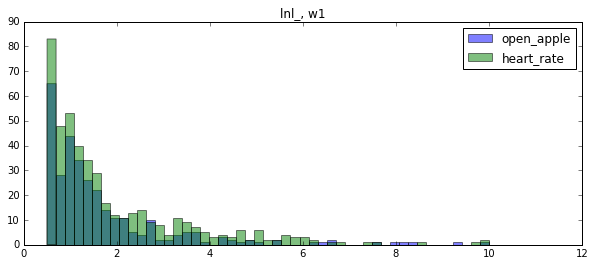

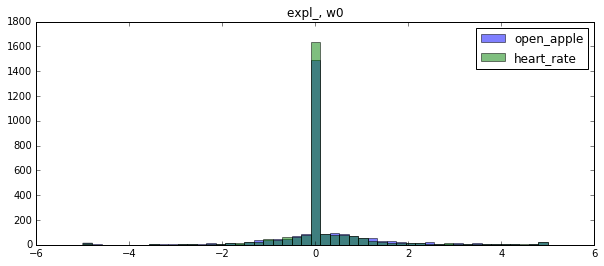

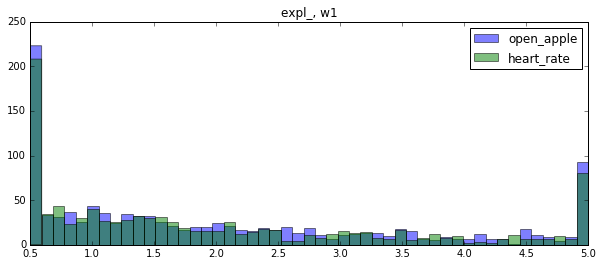

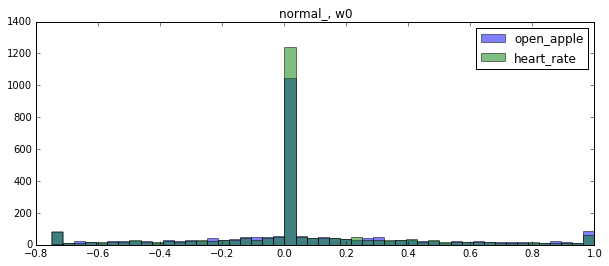

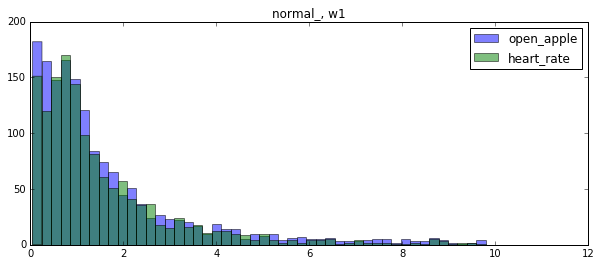

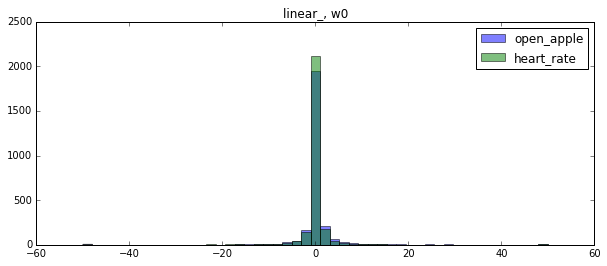

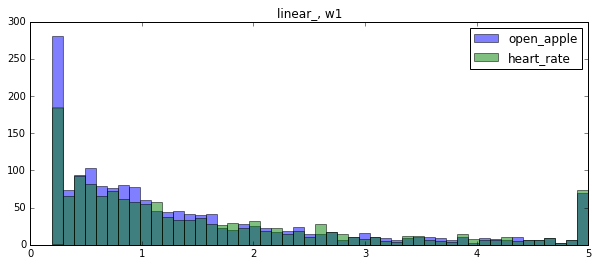

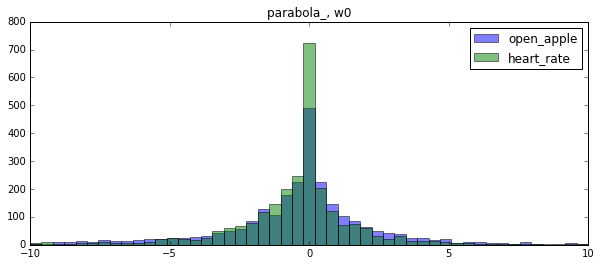

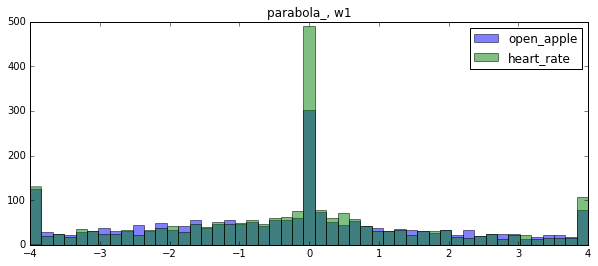

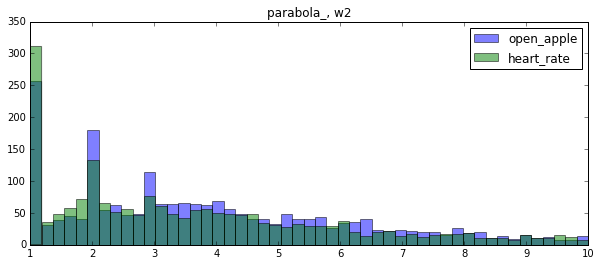

In [68]:
label_vs_set_dict = {label : get_set_of_tokens_params_values(label) for label in ts_labels}
tokens_names         = get_ordered_list_tokens()
_, tokens_num_params = create_map_tokens_params()

number_of_tokens = len(tokens_names)

for index_of_token in range(number_of_tokens):
    token_processed = tokens_names[index_of_token]
    
    for pos_param in range(tokens_num_params[token_processed]):
        plt.figure(figsize = (10,4))
        xaxis_left  = info_tokens[token_processed][1][0][pos_param]
        xaxis_right = info_tokens[token_processed][1][1][pos_param]
        if xaxis_left == -np.inf:
            xaxis_left  = -10
        if xaxis_right == np.inf:
            xaxis_right = 10

        bins = np.linspace(xaxis_left, xaxis_right, 50)

        for label in ts_labels:
            set_values_param_token = label_vs_set_dict[label][token_processed]
            set_values_of_param = [row[pos_param] for row in set_values_param_token]
            plt.hist(set_values_of_param, bins, alpha=0.5, label=label)
            plt.title(token_processed + ', w' + str(pos_param))
            plt.legend(loc='upper right')
            

plt.show()